<a href="https://colab.research.google.com/github/Cheney-Tsai/FiftyOne/blob/main/YOLO_V8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# YOLO v8 堆高機和人員檢測訓練 V2 - Google Colab
# 改進版：優化解壓縮流程和資料夾處理
# ================================================================

# 1. 安裝必要套件
print("正在安裝必要套件...")
!pip install ultralytics
!pip install roboflow

# 2. 導入必要模組
import os
import shutil
from pathlib import Path
import yaml
from ultralytics import YOLO
from google.colab import drive
import zipfile
import glob

# 3. 掛載Google雲端硬碟
print("掛載Google雲端硬碟...")
drive.mount('/content/drive')

# 4. 創建工作目錄
work_dir = '/content/forklift_detection'
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)

print(f"工作目錄: {work_dir}")

正在安裝必要套件...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    U

In [4]:
# ⚠️ 雲端硬碟中的實際路徑
drive_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Forklift and Personal detection.v7i.yolov8.zip'

def extract_and_load_dataset(drive_path):
    """從Google雲端硬碟載入並解壓縮資料集"""
    print(f"嘗試載入: {drive_path}")

    if not os.path.exists(drive_path):
        print(f"❌ 找不到檔案: {drive_path}")
        return False, None

    print(f"✅ 找到資料集: {drive_path}")

    # 如果是壓縮檔，先解壓縮
    if drive_path.endswith(('.zip', '.rar', '.7z')):
        print("📦 解壓縮資料集...")

        try:
            # 清理現有的解壓縮內容
            dataset_dir = './dataset'
            if os.path.exists(dataset_dir):
                shutil.rmtree(dataset_dir)

            with zipfile.ZipFile(drive_path, 'r') as zip_ref:
                # 列出壓縮檔內容
                file_list = zip_ref.namelist()
                print(f"壓縮檔包含 {len(file_list)} 個檔案")

                # 解壓縮到 dataset 目錄
                zip_ref.extractall('./dataset')
                print("✅ 解壓縮完成!")

                # 檢查解壓縮後的結構
                print("\n📁 解壓縮後的結構:")
                for root, dirs, files in os.walk('./dataset'):
                    level = root.replace('./dataset', '').count(os.sep)
                    if level < 3:  # 只顯示前3層
                        indent = '  ' * level
                        folder_name = os.path.basename(root) if level > 0 else 'dataset'
                        print(f'{indent}📁 {folder_name}/')

                        # 顯示資料夾內容概要
                        if level < 2:
                            subindent = '  ' * (level + 1)
                            for d in dirs[:5]:
                                print(f'{subindent}📁 {d}/')

                            image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                            label_files = [f for f in files if f.lower().endswith('.txt')]
                            yaml_files = [f for f in files if f.lower().endswith(('.yaml', '.yml'))]

                            if image_files:
                                print(f'{subindent}🖼️  圖片檔案: {len(image_files)} 個')
                            if label_files:
                                print(f'{subindent}🏷️  標籤檔案: {len(label_files)} 個')
                            if yaml_files:
                                print(f'{subindent}⚙️  配置檔案: {yaml_files}')

                # 尋找實際的資料集根目錄
                dataset_root = find_dataset_root('./dataset')
                return True, dataset_root

        except Exception as e:
            print(f"❌ 解壓縮失敗: {e}")
            return False, None

    else:
        # 如果是目錄，直接複製
        print("📁 複製資料集目錄...")
        try:
            if os.path.exists('./dataset'):
                shutil.rmtree('./dataset')
            shutil.copytree(drive_path, './dataset')
            dataset_root = find_dataset_root('./dataset')
            return True, dataset_root
        except Exception as e:
            print(f"❌ 複製失敗: {e}")
            return False, None

def find_dataset_root(base_path):
    """尋找資料集的實際根目錄"""
    print("\n🔍 尋找資料集根目錄...")

    # 檢查當前目錄是否直接包含 train/valid 目錄
    if os.path.exists(os.path.join(base_path, 'train')) and os.path.exists(os.path.join(base_path, 'valid')):
        print(f"✅ 資料集根目錄: {base_path}")
        return base_path

    # 遞歸搜尋包含 train 和 valid 目錄的資料夾
    for root, dirs, files in os.walk(base_path):
        if 'train' in dirs and ('valid' in dirs or 'val' in dirs):
            print(f"✅ 找到資料集根目錄: {root}")
            return root

    print(f"⚠️  未找到標準的 train/valid 結構，使用: {base_path}")
    return base_path

# 載入和解壓縮資料集
dataset_loaded, dataset_root = extract_and_load_dataset(drive_dataset_path)

if not dataset_loaded:
    print("\n❌ 資料集載入失敗！")
    print("請執行以下步驟:")
    print("1. 將您的資料集上傳到Google雲端硬碟")
    print("2. 修改上面的 drive_dataset_path 變數為正確路徑")
    print("3. 重新執行此程式碼")
    print("\n常見路徑格式:")
    print("- 壓縮檔: '/content/drive/MyDrive/datasets/forklift_dataset.zip'")
    print("- 目錄: '/content/drive/MyDrive/datasets/forklift_dataset'")

    # 列出雲端硬碟內容幫助找到正確路徑
    mydrive_path = '/content/drive/MyDrive'
    if os.path.exists(mydrive_path):
        print(f"\n您的雲端硬碟內容 ({mydrive_path}):")
        for item in os.listdir(mydrive_path)[:20]:
            item_path = os.path.join(mydrive_path, item)
            if os.path.isdir(item_path):
                print(f"📁 {item}/")
            else:
                print(f"📄 {item}")

# 6. 創建 data.yaml 配置檔
def create_data_yaml(dataset_path):
    print("\n⚙️  創建 data.yaml 配置檔...")

    # 尋找現有的 yaml 檔案
    yaml_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.yaml', '.yml')) and ('data' in file.lower() or 'config' in file.lower()):
                yaml_files.append(os.path.join(root, file))

    if yaml_files:
        print(f"📄 找到現有 YAML 檔案: {yaml_files[0]}")
        try:
            with open(yaml_files[0], 'r', encoding='utf-8') as f:
                config = yaml.safe_load(f)
            print("現有配置:")
            for key, value in config.items():
                print(f"  {key}: {value}")

            # 更新路徑為絕對路徑
            if 'train' in config:
                train_path = os.path.join(dataset_path, config['train']) if not os.path.isabs(config['train']) else config['train']
                config['train'] = os.path.abspath(train_path)

            if 'val' in config:
                val_path = os.path.join(dataset_path, config['val']) if not os.path.isabs(config['val']) else config['val']
                config['val'] = os.path.abspath(val_path)

            if 'test' in config:
                test_path = os.path.join(dataset_path, config['test']) if not os.path.isabs(config['test']) else config['test']
                config['test'] = os.path.abspath(test_path)

        except Exception as e:
            print(f"❌ 讀取現有配置失敗: {e}")
            config = create_default_config(dataset_path)
    else:
        print("📝 未找到現有配置，創建預設配置...")
        config = create_default_config(dataset_path)

    # 寫入配置檔案
    with open('data.yaml', 'w', encoding='utf-8') as f:
        yaml.dump(config, f, default_flow_style=False, allow_unicode=True)

    print("\n📋 最終 data.yaml 配置:")
    with open('data.yaml', 'r', encoding='utf-8') as f:
        print(f.read())

    return config

def create_default_config(dataset_path):
    """創建預設配置"""
    print(f"🔍 在 {dataset_path} 中搜尋訓練和驗證目錄...")

    train_path = None
    val_path = None
    test_path = None

    # 根據您的資料集結構，直接檢查標準目錄
    train_dir = os.path.join(dataset_path, 'train')
    valid_dir = os.path.join(dataset_path, 'valid')
    test_dir = os.path.join(dataset_path, 'test')

    # 檢查 train 目錄
    if os.path.exists(train_dir):
        # 優先檢查是否有 images 子目錄
        images_subdir = os.path.join(train_dir, 'images')
        if os.path.exists(images_subdir):
            train_path = images_subdir
            print(f"✅ 找到訓練目錄: {train_path}")
        else:
            # 直接使用 train 目錄
            train_images = [f for f in os.listdir(train_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if train_images:
                train_path = train_dir
                print(f"✅ 找到訓練目錄: {train_path}")

    # 檢查 valid 目錄
    if os.path.exists(valid_dir):
        # 優先檢查是否有 images 子目錄
        images_subdir = os.path.join(valid_dir, 'images')
        if os.path.exists(images_subdir):
            val_path = images_subdir
            print(f"✅ 找到驗證目錄: {val_path}")
        else:
            # 直接使用 valid 目錄
            val_images = [f for f in os.listdir(valid_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if val_images:
                val_path = valid_dir
                print(f"✅ 找到驗證目錄: {val_path}")

    # 檢查 test 目錄
    if os.path.exists(test_dir):
        # 優先檢查是否有 images 子目錄
        images_subdir = os.path.join(test_dir, 'images')
        if os.path.exists(images_subdir):
            test_path = images_subdir
            print(f"✅ 找到測試目錄: {test_path}")
        else:
            # 直接使用 test 目錄
            test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if test_images:
                test_path = test_dir
                print(f"✅ 找到測試目錄: {test_path}")

    # 如果沒找到標準目錄，進行遞歸搜尋
    if not train_path or not val_path:
        print("標準目錄未找到，進行遞歸搜尋...")
        for root, dirs, files in os.walk(dataset_path):
            for dir_name in dirs:
                full_path = os.path.join(root, dir_name)

                if not train_path and dir_name.lower() in ['train', 'training']:
                    images_path = os.path.join(full_path, 'images')
                    if os.path.exists(images_path):
                        train_path = images_path
                        print(f"✅ 遞歸找到訓練目錄: {train_path}")
                    elif len([f for f in os.listdir(full_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) > 0:
                        train_path = full_path
                        print(f"✅ 遞歸找到訓練目錄: {train_path}")

                if not val_path and dir_name.lower() in ['valid', 'validation', 'val']:
                    images_path = os.path.join(full_path, 'images')
                    if os.path.exists(images_path):
                        val_path = images_path
                        print(f"✅ 遞歸找到驗證目錄: {val_path}")
                    elif len([f for f in os.listdir(full_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) > 0:
                        val_path = full_path
                        print(f"✅ 遞歸找到驗證目錄: {val_path}")

                if not test_path and dir_name.lower() in ['test', 'testing']:
                    images_path = os.path.join(full_path, 'images')
                    if os.path.exists(images_path):
                        test_path = images_path
                        print(f"✅ 遞歸找到測試目錄: {test_path}")
                    elif len([f for f in os.listdir(full_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) > 0:
                        test_path = full_path
                        print(f"✅ 遞歸找到測試目錄: {test_path}")

    config = {
        'train': train_path or os.path.join(dataset_path, 'train'),
        'val': val_path or os.path.join(dataset_path, 'valid'),
        'nc': 2,
        'names': ['forklift', 'person']
    }

    if test_path:
        config['test'] = test_path

    return config

# 執行資料集處理
if dataset_loaded and dataset_root:
    data_config = create_data_yaml(dataset_root)
    dataset_valid = validate_dataset(data_config)
else:
    dataset_valid = False


嘗試載入: /content/drive/MyDrive/Colab Notebooks/Forklift and Personal detection.v7i.yolov8.zip
✅ 找到資料集: /content/drive/MyDrive/Colab Notebooks/Forklift and Personal detection.v7i.yolov8.zip
📦 解壓縮資料集...
壓縮檔包含 8300 個檔案
✅ 解壓縮完成!

📁 解壓縮後的結構:
📁 dataset/
  📁 valid/
  📁 train/
  📁 test/
  🏷️  標籤檔案: 2 個
  ⚙️  配置檔案: ['data.yaml']
  📁 valid/
    📁 labels/
    📁 images/
    📁 labels/
    📁 images/
  📁 train/
    📁 labels/
    📁 images/
    📁 labels/
    📁 images/
  📁 test/
    📁 labels/
    📁 images/
    📁 labels/
    📁 images/

🔍 尋找資料集根目錄...
✅ 資料集根目錄: ./dataset

⚙️  創建 data.yaml 配置檔...
📄 找到現有 YAML 檔案: ./dataset/data.yaml
現有配置:
  train: ../train/images
  val: ../valid/images
  test: ../test/images
  nc: 2
  names: ['Forklift', 'Person']
  roboflow: {'workspace': 'naresuan-university-dtbkx', 'project': 'forklift-and-personal-detection', 'version': 7, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/naresuan-university-dtbkx/forklift-and-personal-detection/dataset/7'}

📋 最終 data.yaml 配置:


NameError: name 'validate_dataset' is not defined

In [5]:
#!/usr/bin/env python3
"""
YOLO v8 Forklift Detection Training Script
"""

from ultralytics import YOLO
import yaml
import os

def create_dataset_yaml():
    """創建 dataset.yaml 配置文件"""
    # 修正路徑 - 直接使用相對路徑
    dataset_path = 'content/forklift_detection/dataset'

    config = {
        'path': dataset_path,
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        'nc': 1,  # 類別數量
        'names': ['forklift']  # 類別名稱
    }

    # 檢查路徑是否存在
    if not os.path.exists(dataset_path):
        print(f"❌ 資料集路徑不存在: {dataset_path}")
        print("請確認資料夾結構正確")

        # 嘗試其他可能的路徑
        alt_paths = [
            './content/forklift_detection/dataset',
            '/content/forklift_detection/dataset',
            'forklift_detection/dataset'
        ]

        for alt_path in alt_paths:
            if os.path.exists(alt_path):
                print(f"✅ 找到替代路徑: {alt_path}")
                config['path'] = alt_path
                break
        else:
            return False

    with open('dataset.yaml', 'w') as f:
        yaml.dump(config, f)

    print(f"✅ dataset.yaml 已創建，路徑: {config['path']}")
    return True

def train_model():
    """訓練 YOLO v8 模型"""
    # 載入預訓練模型
    model = YOLO('yolov8n.pt')  # nano版本，可改為 yolov8s.pt, yolov8m.pt

    # 開始訓練
    results = model.train(
        data='dataset.yaml',
        epochs=100,
        imgsz=640,
        batch=16,
        name='forklift_detection',
        patience=10,
        save=True,
        plots=True
    )

    return model, results

def validate_model(model):
    """驗證模型性能"""
    metrics = model.val()
    print(f"📊 mAP50: {metrics.box.map50:.4f}")
    print(f"📊 mAP50-95: {metrics.box.map:.4f}")

    return metrics

def main():
    print("🚀 開始 YOLO v8 叉車檢測訓練...")

    # 創建配置文件
    if not create_dataset_yaml():
        print("❌ 無法創建配置文件，請檢查資料路徑")
        return

    # 訓練模型
    model, results = train_model()

    # 驗證模型
    metrics = validate_model(model)

    # 保存最終模型
    model.save('forklift_best.pt')

    print("✅ 訓練完成！")
    print(f"📁 模型保存至: runs/detect/forklift_detection/weights/best.pt")

if __name__ == "__main__":
    main()

🚀 開始 YOLO v8 叉車檢測訓練...
❌ 資料集路徑不存在: content/forklift_detection/dataset
請確認資料夾結構正確
✅ 找到替代路徑: /content/forklift_detection/dataset
✅ dataset.yaml 已創建，路徑: /content/forklift_detection/dataset


100%|██████████| 6.25M/6.25M [00:00<00:00, 93.0MB/s]


Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=forklift_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

100%|██████████| 755k/755k [00:00<00:00, 23.9MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 86.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1773.3±621.6 MB/s, size: 56.9 KB)


train: Scanning /content/forklift_detection/dataset/train/labels... 2400 images, 0 backgrounds, 1314 corrupt: 100%|██████████| 2400/2400 [00:00<00:00, 3047.62it/s]

train: /content/forklift_detection/dataset/train/images/0J1QKF0HYLEZ_jpg.rf.52ebf57716b5fe806674a345595cd65a.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/forklift_detection/dataset/train/images/0J1QKF0HYLEZ_jpg.rf.66a274be95eaf466cd8e29dc899d351c.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/forklift_detection/dataset/train/images/0_jpg.rf.0e60b9b1e75da14110d18b3fe7205911.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/forklift_detection/dataset/train/images/0_jpg.rf.7d5288a392e22f02b4a377c6b08d6c24.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/forklift_detection/dataset/train/images/0_jpg.rf.bedee43fd8af4b54d69c999ff0fa208b.jpg: ignoring corrupt image/label: Label class 1

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.1 ms, read: 439.0±62.5 MB/s, size: 61.1 KB)


val: Scanning /content/forklift_detection/dataset/valid/labels... 922 images, 0 backgrounds, 266 corrupt: 100%|██████████| 922/922 [00:00<00:00, 1094.11it/s]

val: /content/forklift_detection/dataset/valid/images/0W368NPVUK77_jpg.rf.982e72e54208fe427aaf7eb6c0ce4f41.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/151_jpg.rf.4f263d921daa6afd5629af951e70c6fc.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/151_jpg.rf.ecd81465f8b417a29705f8c0ac9b65c8.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/2w5i5KkzkQv9WsUadryn-1-6hqml_jpg.rf.cba3012616ca52cd7f5bfd5e382aed58.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/32LSCZQDHZO7_jpg.rf.0a7452ed6625470e751150095ad60ba3.jpg: ignoring corrupt image

val: New cache created: /content/forklift_detection/dataset/valid/labels.cache
Plotting labels to runs/detect/forklift_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/forklift_detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.08G      1.096      1.934      1.638         40        640: 100%|██████████| 68/68 [00:22<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.27it/s]

                   all        656        739      0.704      0.612      0.576      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.57G      1.216      1.596      1.727         32        640: 100%|██████████| 68/68 [00:20<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.87it/s]


                   all        656        739      0.085      0.217     0.0402    0.00844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.59G      1.216      1.483      1.737         52        640: 100%|██████████| 68/68 [00:19<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


                   all        656        739      0.377      0.455      0.322       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.6G      1.249      1.481      1.751         38        640: 100%|██████████| 68/68 [00:18<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.04it/s]


                   all        656        739      0.164      0.115     0.0806     0.0229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.62G      1.222      1.352      1.737         36        640: 100%|██████████| 68/68 [00:19<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.40it/s]

                   all        656        739      0.164      0.252     0.0956     0.0241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.63G      1.216      1.335      1.739         46        640: 100%|██████████| 68/68 [00:18<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.89it/s]


                   all        656        739      0.223      0.337      0.164     0.0414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.65G      1.235      1.371      1.735         33        640: 100%|██████████| 68/68 [00:19<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]


                   all        656        739      0.306      0.486      0.304      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.67G      1.151      1.258      1.692         34        640: 100%|██████████| 68/68 [00:18<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.13it/s]

                   all        656        739      0.619      0.547      0.527      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.69G      1.152      1.263      1.684         36        640: 100%|██████████| 68/68 [00:18<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.26it/s]

                   all        656        739      0.472      0.456      0.409       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       2.7G      1.107      1.226      1.655         45        640: 100%|██████████| 68/68 [00:18<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]

                   all        656        739       0.61      0.534      0.553       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.72G      1.136      1.214      1.655         39        640: 100%|██████████| 68/68 [00:20<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]

                   all        656        739      0.642      0.632      0.587      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.74G      1.103      1.234      1.641         33        640: 100%|██████████| 68/68 [00:19<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.88it/s]

                   all        656        739      0.377      0.386      0.308     0.0806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.75G      1.072      1.149      1.606         38        640: 100%|██████████| 68/68 [00:18<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.20it/s]

                   all        656        739      0.716      0.655      0.699      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.77G      1.071      1.129       1.62         36        640: 100%|██████████| 68/68 [00:18<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.06it/s]

                   all        656        739      0.695      0.645      0.661      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.79G      1.051      1.125      1.594         32        640: 100%|██████████| 68/68 [00:19<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.05it/s]


                   all        656        739      0.639      0.592      0.608      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       2.8G      1.051      1.089      1.592         43        640: 100%|██████████| 68/68 [00:19<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.84it/s]


                   all        656        739      0.643      0.601      0.599      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.82G      1.018      1.052      1.571         35        640: 100%|██████████| 68/68 [00:19<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.51it/s]


                   all        656        739      0.695      0.675       0.71      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.84G      1.034      1.067      1.572         37        640: 100%|██████████| 68/68 [00:18<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.04it/s]


                   all        656        739      0.744      0.613      0.646      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.86G     0.9927      1.034      1.549         50        640: 100%|██████████| 68/68 [00:18<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.17it/s]

                   all        656        739       0.78      0.683      0.724      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.87G     0.9817      1.033       1.54         36        640: 100%|██████████| 68/68 [00:20<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.90it/s]


                   all        656        739      0.688      0.671      0.689      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.89G     0.9698      1.009       1.53         37        640: 100%|██████████| 68/68 [00:20<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]

                   all        656        739      0.589      0.506      0.546      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.91G     0.9622      1.001      1.519         36        640: 100%|██████████| 68/68 [00:18<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.06it/s]


                   all        656        739      0.765      0.686      0.726       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.92G     0.9095     0.9294      1.475         38        640: 100%|██████████| 68/68 [00:18<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.20it/s]

                   all        656        739       0.64      0.656      0.642      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.94G     0.9468     0.9584      1.497         39        640: 100%|██████████| 68/68 [00:18<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.91it/s]

                   all        656        739      0.658      0.673      0.639      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.96G     0.9215     0.9131      1.483         42        640: 100%|██████████| 68/68 [00:20<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.88it/s]

                   all        656        739      0.734      0.654      0.709      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.97G      0.892     0.9188      1.467         46        640: 100%|██████████| 68/68 [00:19<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.32it/s]


                   all        656        739      0.714      0.682       0.71       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.99G     0.9446      0.916      1.496         38        640: 100%|██████████| 68/68 [00:18<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.68it/s]

                   all        656        739      0.776      0.712      0.754      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.01G      0.923      0.929       1.49         39        640: 100%|██████████| 68/68 [00:18<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.02it/s]

                   all        656        739      0.623       0.64      0.636      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.03G     0.9163     0.9032       1.47         39        640: 100%|██████████| 68/68 [00:18<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.99it/s]

                   all        656        739      0.789      0.751       0.77      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.04G     0.8945     0.9034      1.456         40        640: 100%|██████████| 68/68 [00:19<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.98it/s]

                   all        656        739      0.867      0.706      0.798      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.06G     0.8748     0.8764      1.441         40        640: 100%|██████████| 68/68 [00:18<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.17it/s]

                   all        656        739      0.797      0.763      0.796      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.08G     0.8849      0.854      1.455         42        640: 100%|██████████| 68/68 [00:18<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.04it/s]

                   all        656        739      0.756      0.697      0.748      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.09G     0.8734     0.8471      1.431         37        640: 100%|██████████| 68/68 [00:18<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.49it/s]

                   all        656        739      0.749        0.7      0.726      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.11G      0.837     0.8027      1.417         35        640: 100%|██████████| 68/68 [00:19<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]


                   all        656        739      0.794       0.71      0.764      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.13G     0.8554     0.8251      1.418         38        640: 100%|██████████| 68/68 [00:21<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.92it/s]

                   all        656        739      0.752       0.71      0.739      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.14G     0.8404     0.7892      1.414         36        640: 100%|██████████| 68/68 [00:19<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.28it/s]


                   all        656        739      0.769      0.667      0.732      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.16G     0.8425     0.8124      1.413         40        640: 100%|██████████| 68/68 [00:18<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.14it/s]

                   all        656        739      0.744      0.671      0.715      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.18G     0.8395     0.8133      1.407         51        640: 100%|██████████| 68/68 [00:18<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]

                   all        656        739      0.726      0.664      0.691      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       3.2G     0.8135     0.7964      1.397         36        640: 100%|██████████| 68/68 [00:19<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.95it/s]


                   all        656        739      0.795      0.738      0.776      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.21G      0.817     0.7657      1.391         46        640: 100%|██████████| 68/68 [00:19<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.43it/s]


                   all        656        739      0.809      0.694      0.766      0.408
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

40 epochs completed in 0.287 hours.
Optimizer stripped from runs/detect/forklift_detection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/forklift_detection/weights/best.pt, 6.2MB

Validating runs/detect/forklift_detection/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]


                   all        656        739      0.867      0.705      0.799      0.445
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/forklift_detection
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1660.3±715.3 MB/s, size: 68.5 KB)


val: Scanning /content/forklift_detection/dataset/valid/labels.cache... 922 images, 0 backgrounds, 266 corrupt: 100%|██████████| 922/922 [00:00<?, ?it/s]

val: /content/forklift_detection/dataset/valid/images/0W368NPVUK77_jpg.rf.982e72e54208fe427aaf7eb6c0ce4f41.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/151_jpg.rf.4f263d921daa6afd5629af951e70c6fc.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/151_jpg.rf.ecd81465f8b417a29705f8c0ac9b65c8.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/2w5i5KkzkQv9WsUadryn-1-6hqml_jpg.rf.cba3012616ca52cd7f5bfd5e382aed58.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/32LSCZQDHZO7_jpg.rf.0a7452ed6625470e751150095ad60ba3.jpg: ignoring corrupt image


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:08<00:00,  4.78it/s]


                   all        656        739      0.867      0.706      0.799      0.445
Speed: 1.1ms preprocess, 4.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/forklift_detection2
📊 mAP50: 0.7986
📊 mAP50-95: 0.4453
✅ 訓練完成！
📁 模型保存至: runs/detect/forklift_detection/weights/best.pt


In [9]:
#!/usr/bin/env python3
"""
YOLO v8 疊加訓練腳本 - 在現有模型基礎上繼續訓練
"""

from ultralytics import YOLO
import yaml
import os

def create_dataset_yaml():
    """創建 dataset.yaml 配置文件"""
    dataset_path = 'content/forklift_detection/dataset'

    config = {
        'path': dataset_path,
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        'nc': 1,
        'names': ['forklift']
    }

    if not os.path.exists(dataset_path):
        alt_paths = [
            './content/forklift_detection/dataset',
            '/content/forklift_detection/dataset',
            'forklift_detection/dataset'
        ]

        for alt_path in alt_paths:
            if os.path.exists(alt_path):
                config['path'] = alt_path
                break
        else:
            return False

    with open('dataset.yaml', 'w') as f:
        yaml.dump(config, f)

    print(f"✅ dataset.yaml 已創建，路徑: {config['path']}")
    return True

def resume_training(model_path, epochs=50, lr_factor=0.1):
    """
    疊加訓練函數

    Args:
        model_path: 現有模型路徑
        epochs: 額外訓練輪數
        lr_factor: 學習率調整係數 (降低學習率避免過度調整)
    """

    print(f"🔄 載入現有模型: {model_path}")

    # 載入已訓練的模型
    model = YOLO(model_path)

    # 繼續訓練 - 使用較低的學習率
    results = model.train(
        data='dataset.yaml',
        epochs=epochs,
        imgsz=640,
        batch=16,
        name='forklift_detection_v2',  # 新的實驗名稱
        lr0=0.01 * lr_factor,  # 降低初始學習率
        patience=15,  # 增加耐心值
        save=True,
        plots=True,
        resume=False,  # 不是恢復訓練，而是在現有權重基礎上訓練
        cache=True,  # 快取圖像加速訓練
        mixup=0.1,   # 數據增強
        mosaic=0.8   # 馬賽克增強
    )

    return model, results

def advanced_resume_training(model_path):
    """進階疊加訓練 - 多階段學習率"""

    model = YOLO(model_path)

    print("🎯 階段1: 微調訓練 (低學習率)")
    results1 = model.train(
        data='dataset.yaml',
        epochs=30,
        lr0=0.001,  # 很低的學習率
        name='forklift_detection_stage1',
        patience=10
    )

    print("🎯 階段2: 精細調整 (極低學習率)")
    results2 = model.train(
        data='dataset.yaml',
        epochs=20,
        lr0=0.0001,  # 極低學習率
        name='forklift_detection_stage2',
        patience=8
    )

    return model, (results1, results2)

def compare_models(original_path, new_path):
    """比較原始模型和新模型性能"""

    print("\n📊 模型性能比較:")

    # 載入模型
    original_model = YOLO(original_path)
    new_model = YOLO(new_path)

    # 驗證兩個模型
    print("🔍 驗證原始模型...")
    original_metrics = original_model.val()

    print("🔍 驗證新模型...")
    new_metrics = new_model.val()

    # 比較結果
    print(f"\n📈 性能提升:")
    print(f"mAP50:     {original_metrics.box.map50:.4f} → {new_metrics.box.map50:.4f} (+{new_metrics.box.map50-original_metrics.box.map50:.4f})")
    print(f"mAP50-95:  {original_metrics.box.map:.4f} → {new_metrics.box.map:.4f} (+{new_metrics.box.map-original_metrics.box.map:.4f})")

    return original_metrics, new_metrics

def find_best_model():
    """自動搜尋最佳模型文件"""
    possible_paths = [
        '/content/forklift_detection/runs/detect/forklift_detection/weights/best.pt',  # 正確路徑
        'runs/detect/forklift_detection/weights/best.pt',
        'runs/detect/forklift_detection2/weights/best.pt',
        'content/forklift_detection/runs/detect/forklift_detection/weights/best.pt',
        'forklift_best.pt',
        './best.pt'
    ]

    print("🔍 搜尋可用的模型文件...")
    for path in possible_paths:
        if os.path.exists(path):
            print(f"✅ 找到模型: {path}")
            return path

    # 搜尋所有可能的 runs 目錄
    search_dirs = [
        '/content/forklift_detection/runs/detect',
        './content/forklift_detection/runs/detect',
        'runs/detect'
    ]

    for search_dir in search_dirs:
        if os.path.exists(search_dir):
            print(f"📁 搜尋目錄: {search_dir}")
            for folder in os.listdir(search_dir):
                weights_path = f'{search_dir}/{folder}/weights/best.pt'
                if os.path.exists(weights_path):
                    print(f"✅ 找到模型: {weights_path}")
                    return weights_path

    return None

def main():
    print("🚀 開始 YOLO v8 疊加訓練...")

    # 創建配置文件
    if not create_dataset_yaml():
        print("❌ 無法創建配置文件")
        return

    # 自動搜尋模型文件
    model_path = find_best_model()

    if not model_path:
        print("❌ 找不到任何可用的模型文件")
        print("請確認以下路徑之一存在模型:")
        print("- runs/detect/forklift_detection/weights/best.pt")

    print("選擇訓練模式:")
    print("1. 標準疊加訓練 (推薦)")
    print("2. 進階多階段訓練")

    choice = input("請選擇 (1/2): ").strip()

    if choice == "2":
        # 進階訓練
        model, results = advanced_resume_training(model_path)
        new_model_path = 'runs/detect/forklift_detection_stage2/weights/best.pt'
    else:
        # 標準疊加訓練
        model, results = resume_training(model_path, epochs=50, lr_factor=0.1)
        new_model_path = 'runs/detect/forklift_detection_v2/weights/best.pt'

    print("✅ 疊加訓練完成！")

    # 比較模型性能
    if os.path.exists(new_model_path):
        compare_models(model_path, new_model_path)

    print(f"📁 新模型保存至: {new_model_path}")

if __name__ == "__main__":
    main()

🚀 開始 YOLO v8 疊加訓練...
✅ dataset.yaml 已創建，路徑: /content/forklift_detection/dataset
🔍 搜尋可用的模型文件...
✅ 找到模型: /content/forklift_detection/runs/detect/forklift_detection/weights/best.pt
選擇訓練模式:
1. 標準疊加訓練 (推薦)
2. 進階多階段訓練
請選擇 (1/2): 1
🔄 載入現有模型: /content/forklift_detection/runs/detect/forklift_detection/weights/best.pt
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, 

train: Scanning /content/forklift_detection/dataset/train/labels.cache... 2400 images, 0 backgrounds, 1314 corrupt: 100%|██████████| 2400/2400 [00:00<?, ?it/s]

train: /content/forklift_detection/dataset/train/images/0J1QKF0HYLEZ_jpg.rf.52ebf57716b5fe806674a345595cd65a.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/forklift_detection/dataset/train/images/0J1QKF0HYLEZ_jpg.rf.66a274be95eaf466cd8e29dc899d351c.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/forklift_detection/dataset/train/images/0_jpg.rf.0e60b9b1e75da14110d18b3fe7205911.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/forklift_detection/dataset/train/images/0_jpg.rf.7d5288a392e22f02b4a377c6b08d6c24.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/forklift_detection/dataset/train/images/0_jpg.rf.bedee43fd8af4b54d69c999ff0fa208b.jpg: ignoring corrupt image/label: Label class 1


train: Caching images (1.2GB RAM): 100%|██████████| 1086/1086 [00:02<00:00, 370.80it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 619.6±318.7 MB/s, size: 56.3 KB)


val: Scanning /content/forklift_detection/dataset/valid/labels.cache... 922 images, 0 backgrounds, 266 corrupt: 100%|██████████| 922/922 [00:00<?, ?it/s]

val: /content/forklift_detection/dataset/valid/images/0W368NPVUK77_jpg.rf.982e72e54208fe427aaf7eb6c0ce4f41.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/151_jpg.rf.4f263d921daa6afd5629af951e70c6fc.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/151_jpg.rf.ecd81465f8b417a29705f8c0ac9b65c8.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/2w5i5KkzkQv9WsUadryn-1-6hqml_jpg.rf.cba3012616ca52cd7f5bfd5e382aed58.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/32LSCZQDHZO7_jpg.rf.0a7452ed6625470e751150095ad60ba3.jpg: ignoring corrupt image

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.8GB RAM): 100%|██████████| 656/656 [00:03<00:00, 204.03it/s]


Plotting labels to runs/detect/forklift_detection_v2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/forklift_detection_v2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.41G     0.9708     0.9615      1.558         43        640: 100%|██████████| 68/68 [00:20<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.83it/s]

                   all        656        739      0.816      0.724      0.798      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.57G     0.9645     0.9739      1.549         23        640: 100%|██████████| 68/68 [00:18<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.49it/s]

                   all        656        739      0.604      0.593      0.609      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.57G     0.9704     0.9785      1.557         39        640: 100%|██████████| 68/68 [00:18<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.11it/s]

                   all        656        739      0.578      0.528      0.525      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.57G       1.02      1.035      1.591         35        640: 100%|██████████| 68/68 [00:18<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]

                   all        656        739      0.743      0.679      0.707      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.57G      1.008     0.9778      1.568         51        640: 100%|██████████| 68/68 [00:17<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.56it/s]

                   all        656        739      0.752      0.703      0.749      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.57G      1.007      1.004      1.581         40        640: 100%|██████████| 68/68 [00:18<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]

                   all        656        739      0.744      0.655      0.728      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.57G      1.004      1.034       1.58         39        640: 100%|██████████| 68/68 [00:17<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


                   all        656        739      0.672      0.628      0.667      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.57G     0.9512     0.9366      1.531         35        640: 100%|██████████| 68/68 [00:17<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.26it/s]

                   all        656        739      0.768      0.681      0.757      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.57G     0.9557     0.9662      1.524         38        640: 100%|██████████| 68/68 [00:18<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.06it/s]

                   all        656        739      0.795      0.694      0.768      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.57G     0.9388     0.9496      1.516         38        640: 100%|██████████| 68/68 [00:17<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]

                   all        656        739      0.832      0.723      0.796      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.57G      0.932     0.9104      1.498         35        640: 100%|██████████| 68/68 [00:17<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.70it/s]

                   all        656        739      0.615      0.597      0.594       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.57G     0.9654     0.9764       1.54         42        640: 100%|██████████| 68/68 [00:18<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.01it/s]

                   all        656        739      0.832      0.678      0.779      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.57G     0.9462     0.9095      1.524         33        640: 100%|██████████| 68/68 [00:17<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.28it/s]


                   all        656        739      0.797      0.722      0.753      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.57G     0.9459     0.9317      1.533         43        640: 100%|██████████| 68/68 [00:18<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.49it/s]

                   all        656        739      0.824       0.73      0.805      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.57G     0.9234     0.8909      1.512         37        640: 100%|██████████| 68/68 [00:17<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]

                   all        656        739      0.825       0.72      0.776      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.57G     0.8684     0.8372       1.46         35        640: 100%|██████████| 68/68 [00:17<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]

                   all        656        739      0.795      0.731       0.78      0.411
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 0.106 hours.
Optimizer stripped from runs/detect/forklift_detection_v2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/forklift_detection_v2/weights/best.pt, 6.2MB

Validating runs/detect/forklift_detection_v2/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.82it/s]


                   all        656        739      0.819      0.724      0.799      0.444
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/forklift_detection_v2
✅ 疊加訓練完成！

📊 模型性能比較:
🔍 驗證原始模型...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1361.6±451.3 MB/s, size: 42.0 KB)


val: Scanning /content/forklift_detection/dataset/valid/labels.cache... 922 images, 0 backgrounds, 266 corrupt: 100%|██████████| 922/922 [00:00<?, ?it/s]

val: /content/forklift_detection/dataset/valid/images/0W368NPVUK77_jpg.rf.982e72e54208fe427aaf7eb6c0ce4f41.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/151_jpg.rf.4f263d921daa6afd5629af951e70c6fc.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/151_jpg.rf.ecd81465f8b417a29705f8c0ac9b65c8.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/2w5i5KkzkQv9WsUadryn-1-6hqml_jpg.rf.cba3012616ca52cd7f5bfd5e382aed58.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/32LSCZQDHZO7_jpg.rf.0a7452ed6625470e751150095ad60ba3.jpg: ignoring corrupt image


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:08<00:00,  4.85it/s]


                   all        656        739      0.867      0.706      0.799      0.445
Speed: 1.1ms preprocess, 3.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val
🔍 驗證新模型...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1300.6±635.6 MB/s, size: 64.7 KB)


val: Scanning /content/forklift_detection/dataset/valid/labels.cache... 922 images, 0 backgrounds, 266 corrupt: 100%|██████████| 922/922 [00:00<?, ?it/s]

val: /content/forklift_detection/dataset/valid/images/0W368NPVUK77_jpg.rf.982e72e54208fe427aaf7eb6c0ce4f41.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/151_jpg.rf.4f263d921daa6afd5629af951e70c6fc.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/151_jpg.rf.ecd81465f8b417a29705f8c0ac9b65c8.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/2w5i5KkzkQv9WsUadryn-1-6hqml_jpg.rf.cba3012616ca52cd7f5bfd5e382aed58.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/forklift_detection/dataset/valid/images/32LSCZQDHZO7_jpg.rf.0a7452ed6625470e751150095ad60ba3.jpg: ignoring corrupt image


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:08<00:00,  5.02it/s]


                   all        656        739      0.818      0.725      0.798      0.444
Speed: 1.1ms preprocess, 3.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val2

📈 性能提升:
mAP50:     0.7986 → 0.7985 (+-0.0001)
mAP50-95:  0.4453 → 0.4435 (+-0.0017)
📁 新模型保存至: runs/detect/forklift_detection_v2/weights/best.pt


In [11]:
# 掛載 Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 複製模型到 Drive
import shutil
shutil.copy('/content/forklift_detection/runs/detect/forklift_detection_v2/weights/best.pt',
           '/content/drive/MyDrive/forklift_best_model.pt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/forklift_best_model.pt'

🚀 開始 YOLO 叉車偵測測試...
✅ 找到模型: runs/detect/forklift_detection_v2/weights/best.pt
📁 搜尋目錄: /content/forklift_detection/dataset/test/images
✅ 選取了 2 張測試圖片

image 1/1 /content/forklift_detection/dataset/test/images/n03384352_2083_JPEG.rf.37f538694d85dff0871d936371fd0173.jpg: 640x640 1 forklift, 9.7ms
Speed: 6.8ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/forklift_detection/dataset/test/images/n03384352_5343_JPEG.rf.25daa6f9f9b5fa2d9fba0f099919481d.jpg: 640x640 2 forklifts, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


<ipython-input-14-4fb8adeae5ee>:99: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-4fb8adeae5ee>:99: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-4fb8adeae5ee>:99: UserWarning: Glyph 20597 (\N{CJK UNIFIED IDEOGRAPH-5075}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-4fb8adeae5ee>:99: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-4fb8adeae5ee>:99: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-4fb8adeae5ee>:99: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-4fb8adeae5ee>:100: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing fro

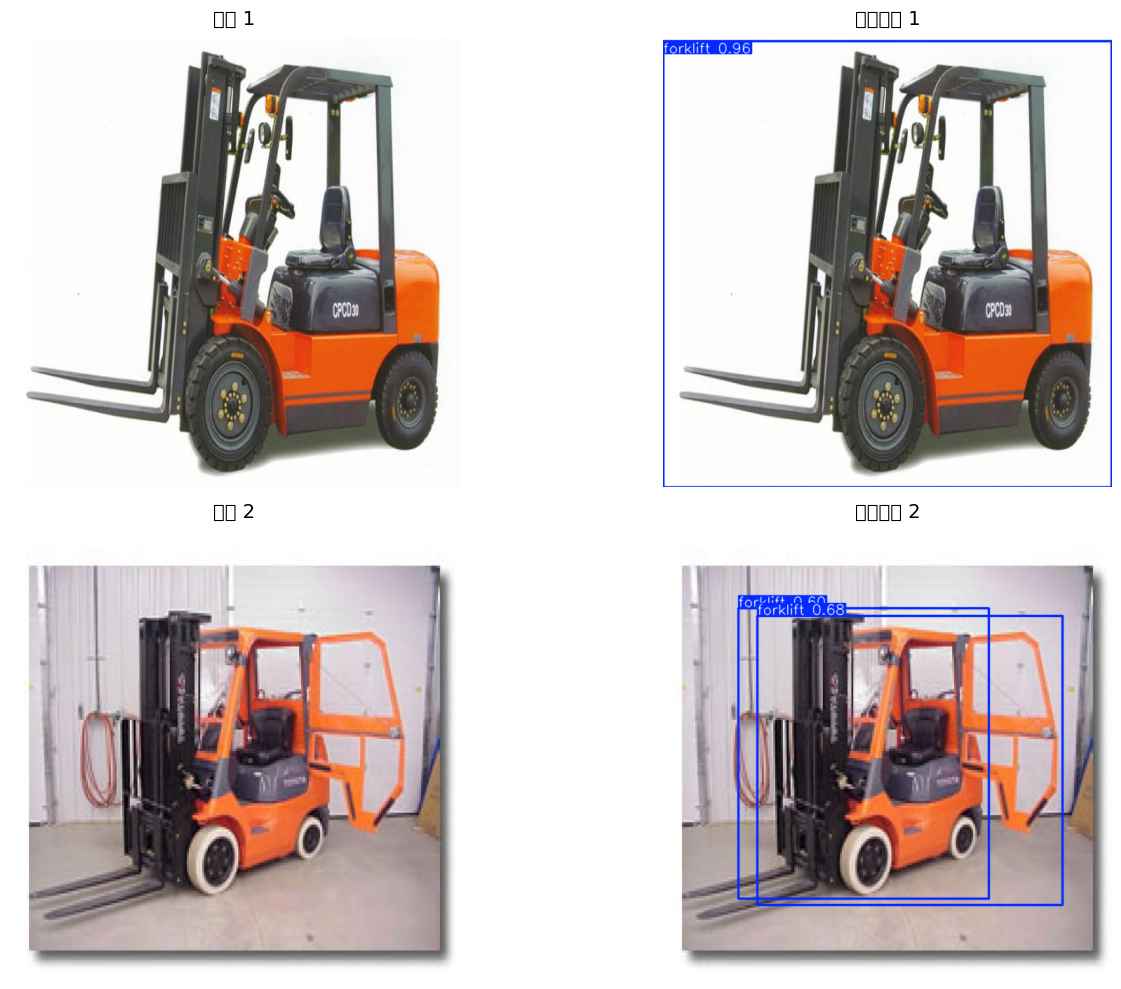

✅ 偵測完成！結果已保存為 detection_results.png
🚀 開始 YOLO 叉車偵測測試...
✅ 找到模型: runs/detect/forklift_detection_v2/weights/best.pt
📁 搜尋目錄: /content/forklift_detection/dataset/test/images
✅ 選取了 2 張測試圖片

📸 選取的測試圖片:
  - /content/forklift_detection/dataset/test/images/n03384352_5361_JPEG.rf.a2b4f72d8db85f897d9d26610ee854ec.jpg
  - /content/forklift_detection/dataset/test/images/Y3CQCAW80H94_jpg.rf.73da972ccda3dffd2c4b07baa4b2e229.jpg

🎯 開始偵測 (信心度閾值: 0.5)...

image 1/1 /content/forklift_detection/dataset/test/images/n03384352_5361_JPEG.rf.a2b4f72d8db85f897d9d26610ee854ec.jpg: 640x640 (no detections), 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/forklift_detection/dataset/test/images/Y3CQCAW80H94_jpg.rf.73da972ccda3dffd2c4b07baa4b2e229.jpg: 640x640 (no detections), 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


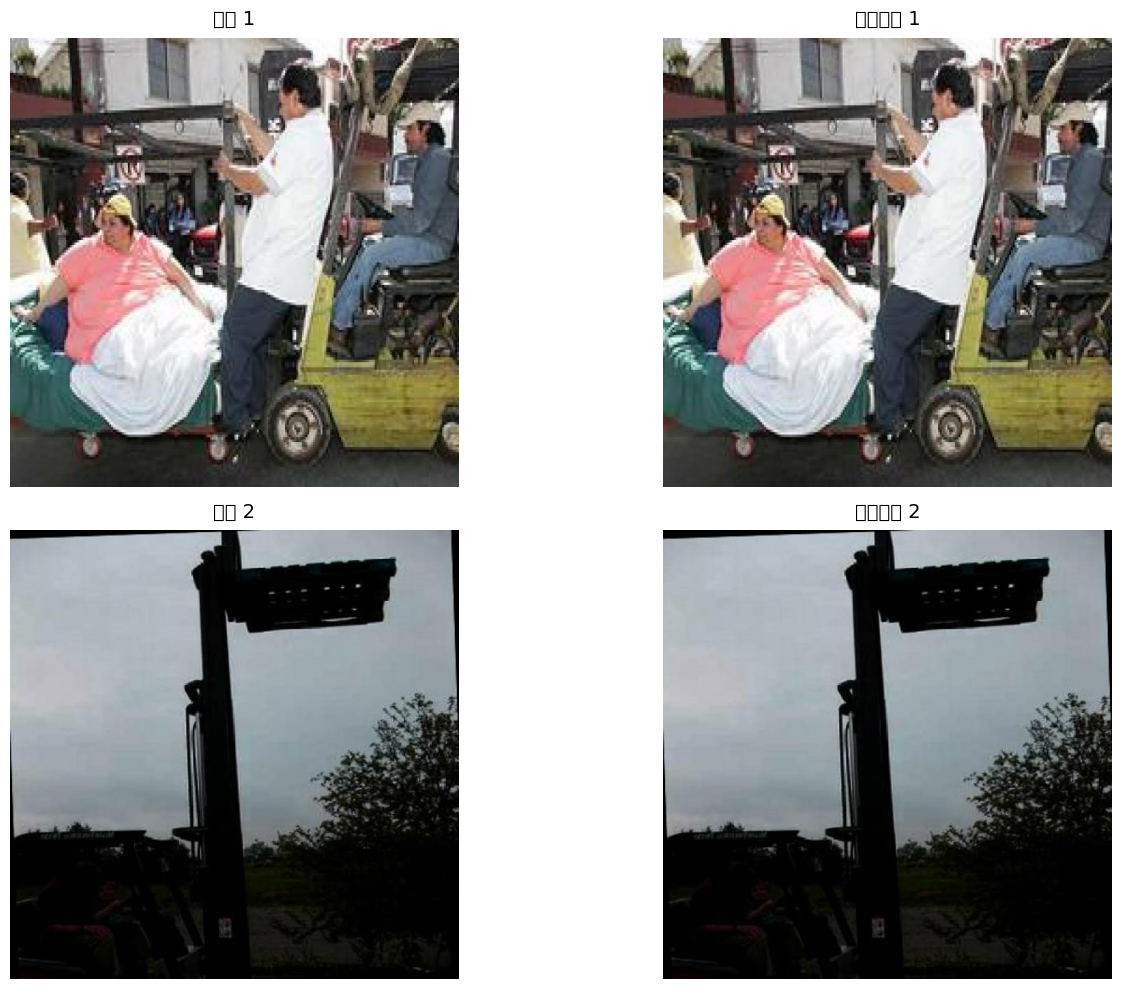


🔬 測試不同信心度閾值效果...

image 1/1 /content/forklift_detection/dataset/test/images/n03384352_5361_JPEG.rf.a2b4f72d8db85f897d9d26610ee854ec.jpg: 640x640 (no detections), 10.9ms
Speed: 2.6ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/forklift_detection/dataset/test/images/n03384352_5361_JPEG.rf.a2b4f72d8db85f897d9d26610ee854ec.jpg: 640x640 (no detections), 8.8ms
Speed: 2.4ms preprocess, 8.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/forklift_detection/dataset/test/images/n03384352_5361_JPEG.rf.a2b4f72d8db85f897d9d26610ee854ec.jpg: 640x640 (no detections), 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/forklift_detection/dataset/test/images/n03384352_5361_JPEG.rf.a2b4f72d8db85f897d9d26610ee854ec.jpg: 640x640 (no detections), 11.0ms
Speed: 2.5ms preprocess, 11.0ms inference, 1.1ms postprocess per image at shape (1, 3, 

<ipython-input-14-4fb8adeae5ee>:125: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-4fb8adeae5ee>:125: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-4fb8adeae5ee>:125: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-4fb8adeae5ee>:125: UserWarning: Glyph 38334 (\N{CJK UNIFIED IDEOGRAPH-95BE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-4fb8adeae5ee>:125: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-4fb8adeae5ee>:125: UserWarning: Glyph 20597 (\N{CJK UNIFIED IDEOGRAPH-5075}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-4fb8adeae5ee>:125: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missi

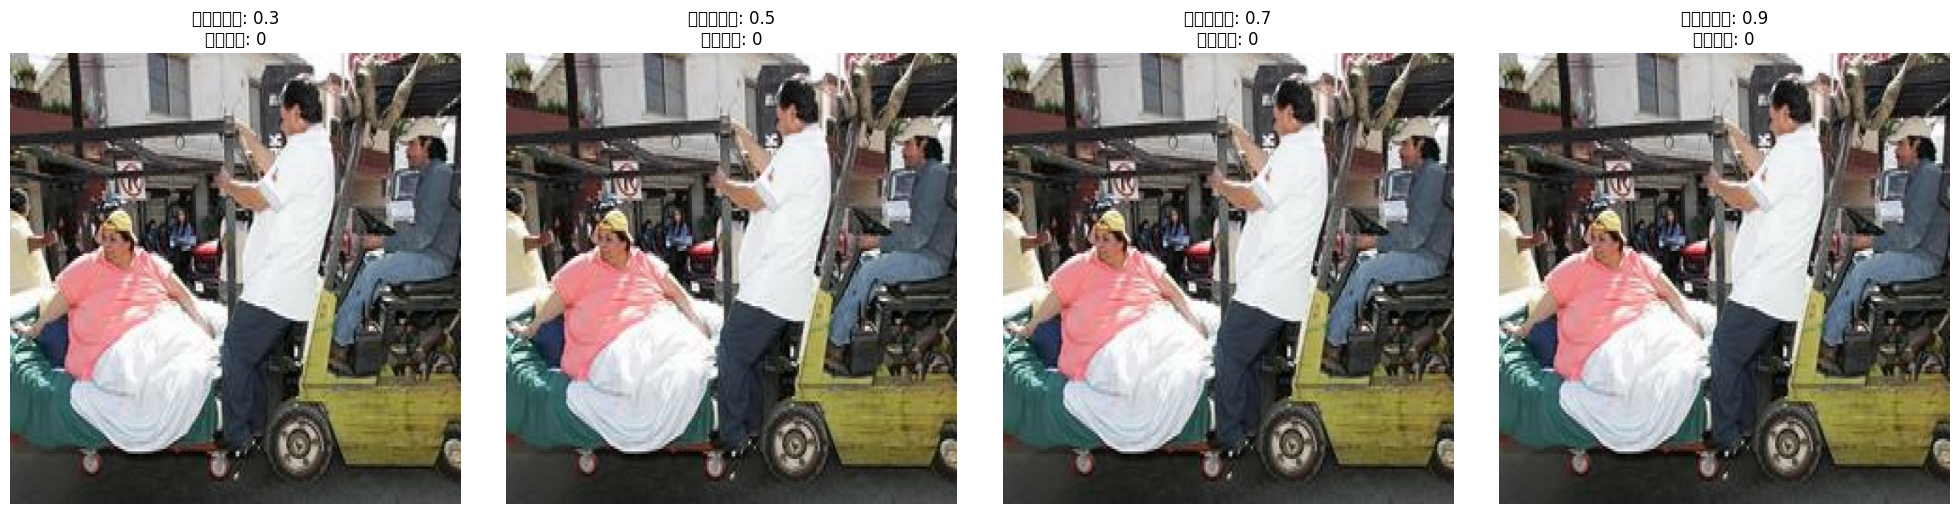

✅ 測試完成！
📁 結果已保存為:
  - detection_results.png (偵測結果)
  - threshold_comparison.png (閾值比較)


In [14]:
#!/usr/bin/env python3
"""
YOLO v8 堆高機偵測測試腳本
使用訓練好的模型對測試圖片進行偵測
"""

import os
import random
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

def find_test_images(test_dir='content/forklift_detection/dataset/test/images', num_images=2):
    """從測試資料夾中隨機選取圖片"""

    # 可能的測試圖片路徑
    possible_dirs = [
        'content/forklift_detection/dataset/test/images',
        '/content/forklift_detection/dataset/test/images',
        './content/forklift_detection/dataset/test/images',
        'content/forklift_detection/dataset/train/images'  # 如果test沒有圖片，用train的
    ]

    test_images = []

    for test_dir in possible_dirs:
        if os.path.exists(test_dir):
            print(f"📁 搜尋目錄: {test_dir}")

            # 獲取所有圖片文件
            image_files = [f for f in os.listdir(test_dir)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

            if len(image_files) >= num_images:
                # 隨機選取指定數量的圖片
                selected = random.sample(image_files, num_images)
                test_images = [os.path.join(test_dir, img) for img in selected]
                print(f"✅ 選取了 {len(test_images)} 張測試圖片")
                break

    if not test_images:
        print("❌ 找不到測試圖片")
        return None

    return test_images

def load_model(model_path='runs/detect/forklift_detection_v2/weights/best.pt'):
    """載入訓練好的模型"""

    # 檢查模型是否存在
    possible_paths = [
        'runs/detect/forklift_detection_v2/weights/best.pt',
        '/content/forklift_detection/runs/detect/forklift_detection_v2/weights/best.pt',
        'runs/detect/forklift_detection/weights/best.pt',
        '/content/forklift_detection/runs/detect/forklift_detection/weights/best.pt'
    ]

    for path in possible_paths:
        if os.path.exists(path):
            print(f"✅ 找到模型: {path}")
            model = YOLO(path)
            return model

    print("❌ 找不到模型文件")
    return None

def detect_and_display(model, image_paths, conf_threshold=0.5):
    """對圖片進行偵測並顯示結果 - 簡潔版本"""

    plt.figure(figsize=(15, 10))

    for idx, image_path in enumerate(image_paths):
        # 讀取原始圖片
        original_img = cv2.imread(image_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        # 進行偵測
        results = model(image_path, conf=conf_threshold)
        result = results[0]

        # 繪製偵測結果
        detected_img = result.plot()  # YOLO內建的繪圖功能
        detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

        # 顯示原圖
        plt.subplot(2, 2, idx*2 + 1)
        plt.imshow(original_img)
        plt.title(f'原圖 {idx+1}', fontsize=14, pad=10)
        plt.axis('off')

        # 顯示偵測結果
        plt.subplot(2, 2, idx*2 + 2)
        plt.imshow(detected_img)
        plt.title(f'偵測結果 {idx+1}', fontsize=14, pad=10)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('detection_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def test_different_thresholds(model, image_path):
    """測試不同信心度閾值的偵測效果"""

    thresholds = [0.3, 0.5, 0.7, 0.9]

    plt.figure(figsize=(20, 5))

    for idx, threshold in enumerate(thresholds):
        results = model(image_path, conf=threshold)
        result = results[0]
        detected_img = result.plot()
        detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 4, idx + 1)
        plt.imshow(detected_img)

        boxes = result.boxes
        num_detections = len(boxes) if boxes is not None else 0

        plt.title(f'信心度閾值: {threshold}\n偵測數量: {num_detections}', fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('threshold_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    print("🚀 開始 YOLO 叉車偵測測試...")

    # 載入模型
    model = load_model()
    if not model:
        return

    # 找測試圖片
    test_images = find_test_images(num_images=2)
    if not test_images:
        return

    # 偵測並顯示結果 - 僅顯示視覺結果
    detect_and_display(model, test_images, conf_threshold=0.5)

    print("✅ 偵測完成！結果已保存為 detection_results.png")
    print("🚀 開始 YOLO 叉車偵測測試...")

    # 載入模型
    model = load_model()
    if not model:
        return

    # 找測試圖片
    test_images = find_test_images(num_images=2)
    if not test_images:
        return

    print(f"\n📸 選取的測試圖片:")
    for img in test_images:
        print(f"  - {img}")

    # 偵測並顯示結果
    print(f"\n🎯 開始偵測 (信心度閾值: 0.5)...")
    detect_and_display(model, test_images, conf_threshold=0.5)

    # 測試不同閾值 (使用第一張圖片)
    if len(test_images) > 0:
        print(f"\n🔬 測試不同信心度閾值效果...")
        test_different_thresholds(model, test_images[0])

    print("✅ 測試完成！")
    print("📁 結果已保存為:")
    print("  - detection_results.png (偵測結果)")
    print("  - threshold_comparison.png (閾值比較)")

if __name__ == "__main__":
    main()